<a href="https://www.kaggle.com/code/aneeshgrover/thapar-summer-school?scriptVersionId=185308180" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [159]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import log_loss

from scipy.stats import randint

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/thapar-summer-school-2024/sample_submission.csv
/kaggle/input/thapar-summer-school-2024/train.csv
/kaggle/input/thapar-summer-school-2024/test.csv


# Loading the data

In [145]:
train = pd.read_csv('/kaggle/input/thapar-summer-school-2024/train.csv')
test = pd.read_csv('/kaggle/input/thapar-summer-school-2024/test.csv')
sample_submission = pd.read_csv('/kaggle/input/thapar-summer-school-2024/sample_submission.csv')

print("\nTrain Data : ")
print(train.head())

print("\nTest Data : ")
print(test.head())

print("\nSample Submission : ")
print(sample_submission.head())


Train Data : 
   id  N_Days             Drug    Age Sex Ascites Hepatomegaly Spiders Edema  \
0   0     999  D-penicillamine  21532   M       N            N       N     N   
1   1    2574          Placebo  19237   F       N            N       N     N   
2   2    3428          Placebo  13727   F       N            Y       Y     Y   
3   3    2576          Placebo  18460   F       N            N       N     N   
4   4     788          Placebo  16658   F       N            Y       N     N   

   Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  \
0        2.3        316.0     3.35   172.0    1601.0  179.80           63.0   
1        0.9        364.0     3.54    63.0    1440.0  134.85           88.0   
2        3.3        299.0     3.55   131.0    1029.0  119.35           50.0   
3        0.6        256.0     3.50    58.0    1653.0   71.30           96.0   
4        1.1        346.0     3.65    63.0    1181.0  125.55           96.0   

   Platelets  Prothrombin  St

# Exploring the Data

In [146]:
print("\nTrain Data Shape", train.shape)
print("Test Data Shapa", test.shape)

print("\nMissing Values in Train Data: ")
print(train.isnull().sum())

print("\nMissing Values in Test data: ")
print(train.isnull().sum())

print("/nTrain Data Summary")
print(train.describe())


Train Data Shape (7905, 20)
Test Data Shapa (5271, 19)

Missing Values in Train Data: 
id               0
N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
Status           0
dtype: int64

Missing Values in Test data: 
id               0
N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
Status           0
dtype: int64
/nTrain Data Summary
                id       N_Days           Age    Bilirubin  Cholesterol  \

## Visualization

### 1. Histogram

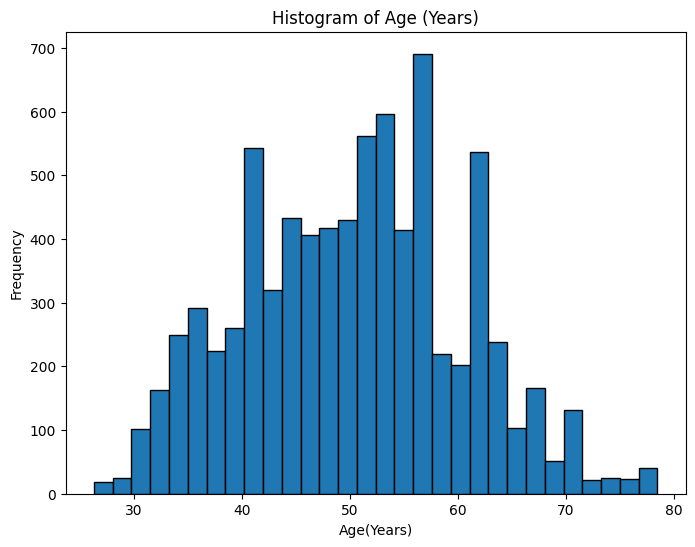

In [147]:
plt.figure(figsize = (8, 6))
plt.hist(train['Age']/365, bins = 30, edgecolor = 'black')
plt.xlabel('Age(Years)')
plt.ylabel('Frequency')
plt.title('Histogram of Age (Years)')
plt.show()

### 2. Count Plots

Text(0.5, 1.0, 'Count of Male and Female')

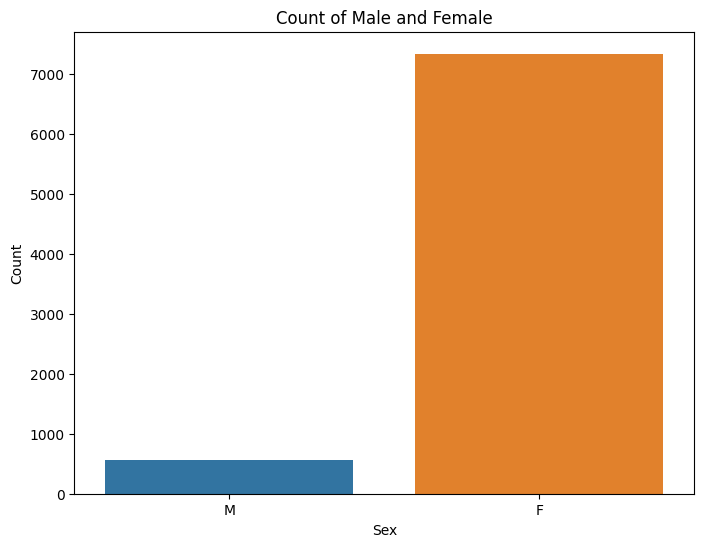

In [148]:
plt.figure(figsize = (8, 6))
sns.countplot(x = 'Sex', data = train)
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Count of Male and Female')

# Preprocessing the Data

In [149]:
print(train.columns)

Index(['id', 'N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Status'],
      dtype='object')


## Drop Unique Columns

In [150]:
def dropUniqueColumns(dataFrame):
    
    uniqueCounts = dataFrame.nunique()
    
    uniqueColumns = uniqueCounts[uniqueCounts == 1].index
    
    dataFrame.drop(columns = uniqueColumns, inplace = True)
    
    return dataFrame

train = dropUniqueColumns(train)
test = dropUniqueColumns(test)
print(train.columns)
print(test.columns)

Index(['id', 'N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Status'],
      dtype='object')
Index(['id', 'N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object')


## Separate Features and Target

In [151]:
X_train = train.drop(['Status'], axis = 1)
Y_train = train['Status']

print(X_train.columns)
print(Y_train.head())

Index(['id', 'N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object')
0    D
1    C
2    D
3    C
4    C
Name: Status, dtype: object


## Label Encoding Categorial Values

In [152]:
categorialColumns = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

labelEncoders = {}
for column in categorialColumns:
    le = LabelEncoder()
    X_train[column] = le.fit_transform(X_train[column])
    test[column] = le.transform(test[column])
    labelEncoders[column] = le

print(X_train.head())
print(test.head())

label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)

   id  N_Days  Drug    Age  Sex  Ascites  Hepatomegaly  Spiders  Edema  \
0   0     999     0  21532    1        0             0        0      0   
1   1    2574     1  19237    0        0             0        0      0   
2   2    3428     1  13727    0        0             1        1      2   
3   3    2576     1  18460    0        0             0        0      0   
4   4     788     1  16658    0        0             1        0      0   

   Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  \
0        2.3        316.0     3.35   172.0    1601.0  179.80           63.0   
1        0.9        364.0     3.54    63.0    1440.0  134.85           88.0   
2        3.3        299.0     3.55   131.0    1029.0  119.35           50.0   
3        0.6        256.0     3.50    58.0    1653.0   71.30           96.0   
4        1.1        346.0     3.65    63.0    1181.0  125.55           96.0   

   Platelets  Prothrombin  Stage  
0      394.0          9.7    3.0  
1      361

## Scaling the data

In [153]:
numericalColumnsTrain = X_train.select_dtypes(include = ['float64', 'int64']).columns
numericalColumnsTest = test.select_dtypes(include = ['float64', 'int64']).columns

scaler = StandardScaler()

X_train[numericalColumnsTrain] = scaler.fit_transform(X_train[numericalColumnsTrain])
test[numericalColumnsTest] = scaler.transform(test[numericalColumnsTest])

print(X_train.head())
print(test.head())

         id    N_Days      Drug       Age       Sex   Ascites  Hepatomegaly  \
0 -1.731832 -0.942430 -1.014655  0.858448  3.590654 -0.224718     -1.022906   
1 -1.731393  0.497025  0.985557  0.234760 -0.278501 -0.224718     -1.022906   
2 -1.730955  1.277529  0.985557 -1.262634 -0.278501 -0.224718      0.977607   
3 -1.730517  0.498852  0.985557  0.023603 -0.278501 -0.224718     -1.022906   
4 -1.730079 -1.135271  0.985557 -0.466107 -0.278501 -0.224718      0.977607   

    Spiders     Edema  Bilirubin  Cholesterol   Albumin    Copper  Alk_Phos  \
0 -0.570095 -0.303472  -0.077237    -0.176908 -0.572940  1.160785 -0.113334   
1 -0.570095 -0.303472  -0.444429     0.068784 -0.024043 -0.275420 -0.197909   
2  1.754093  4.102312   0.185043    -0.263923  0.004846  0.620561 -0.413812   
3 -0.570095 -0.303472  -0.523113    -0.484022 -0.139601 -0.341301 -0.086017   
4 -0.570095 -0.303472  -0.391973    -0.023351  0.293739 -0.275420 -0.333965   

       SGOT  Tryglicerides  Platelets  Prothrombin

In [154]:
X_train_split, X_valid, y_train_split, y_valid = train_test_split(X_train, Y_train_encoded, test_size=0.2, random_state=42)

# Model Training

## Hyperparameter Tuning

In [155]:
def objective(trial):
    params = {
        'objective' : 'multi:softprob', 
        'eval_metric' : 'mlogloss', 
        'num_class' : len(set(Y_train)), 
        'booster' : 'gbtree', 
        'tree_method' : 'hist', 
        'max_depth' : trial.suggest_int('max_depth', 3, 10), 
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000), 
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.5), 
        'subsample': trial.suggest_float('subsample', 0.5, 1.0), 
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0), 
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 0.1, 10.0),
    }
    
    model = XGBClassifier(**params, random_state = 42, use_label_encoder = False)
    model.fit(X_train_split, y_train_split, eval_set=[(X_valid, y_valid)], early_stopping_rounds=10, verbose=False)
    
    Predictions = model.predict_proba(X_valid)
    loss = log_loss(y_valid, Predictions)
    
    return loss

study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 50, timeout = 3600)

print("Best Parameters Found : ")
print(study.best_params)

[I 2024-06-25 10:49:29,659] A new study created in memory with name: no-name-1f86cd9e-4364-4a72-8706-06e97cbd17a7
/tmp/ipykernel_34/1834345444.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
/tmp/ipykernel_34/1834345444.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 0.1, 10.0),
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-0

Best Parameters Found : 
{'max_depth': 3, 'n_estimators': 888, 'learning_rate': 0.10786910749542782, 'subsample': 0.7039877634757948, 'colsample_bytree': 0.6389075139242973, 'gamma': 1.2582699667124653e-05, 'min_child_weight': 0.10577867768014379}


In [139]:
best_params = study.best_params

kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)

xgb_model = XGBClassifier(**best_params, random_state = 42, use_label_encoder = False)
rf_model = RandomForestClassifier(random_state = 42)

ensemble_model = VotingClassifier(estimators = [
    ('xgb', xgb_model), 
    ('rf', rf_model)
], voting = 'soft')



ensemble_model.fit(X_train, Y_train_encoded)

ensemblePredictions = ensemble_model.predict_proba(test)

#valuePredictions = best_model.predict_proba(test)

# Submission File

In [140]:
Submission = pd.DataFrame(ensemblePredictions, columns=["Status_C", "Status_CL", "Status_D"])
smth = pd.read_csv('/kaggle/input/thapar-summer-school-2024/test.csv')
Submission['id'] = smth['id']
Submission = Submission[['id', 'Status_C', 'Status_CL', 'Status_D']]

In [141]:
Submission.to_csv("submission.csv", index=False)
print("Submission file created successfully.")

Submission file created successfully.
